<a href="https://colab.research.google.com/github/zhaotongjie222/-/blob/main/sml_group_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training set samples: 1120, Test set samples: 480
--------------------------------------------------
[Scenario A: Random Forest Baseline]
Baseline Model Accuracy: 0.8854

Baseline Classification Report:
                   precision    recall  f1-score   support

high_bike_demand       0.67      0.58      0.62        78
 low_bike_demand       0.92      0.95      0.93       402

        accuracy                           0.89       480
       macro avg       0.80      0.76      0.78       480
    weighted avg       0.88      0.89      0.88       480

--------------------------------------------------
[Scenario B: Lasso Selection + Random Forest]
Lasso kept 6/12 features
Dropped features: ['day_of_week', 'holiday', 'precip', 'snowdepth', 'windspeed', 'visibility']
Selected features: ['hour_of_day', 'month', 'weekday', 'summertime', 'temp', 'humidity']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Model Accuracy after Lasso: 0.8896

Classification Report after Lasso:
                   precision    recall  f1-score   support

high_bike_demand       0.68      0.62      0.64        78
 low_bike_demand       0.93      0.94      0.93       402

        accuracy                           0.89       480
       macro avg       0.80      0.78      0.79       480
    weighted avg       0.89      0.89      0.89       480

--------------------------------------------------
[Final Comparison]
Original feature count: 12 -> Accuracy: 88.54%
Selected feature count: 6 -> Accuracy: 88.96%
Conclusion: Lasso selection is effective. Performance maintained or improved with fewer features.

--------------------------------------------------
[Model Performance Visualization]


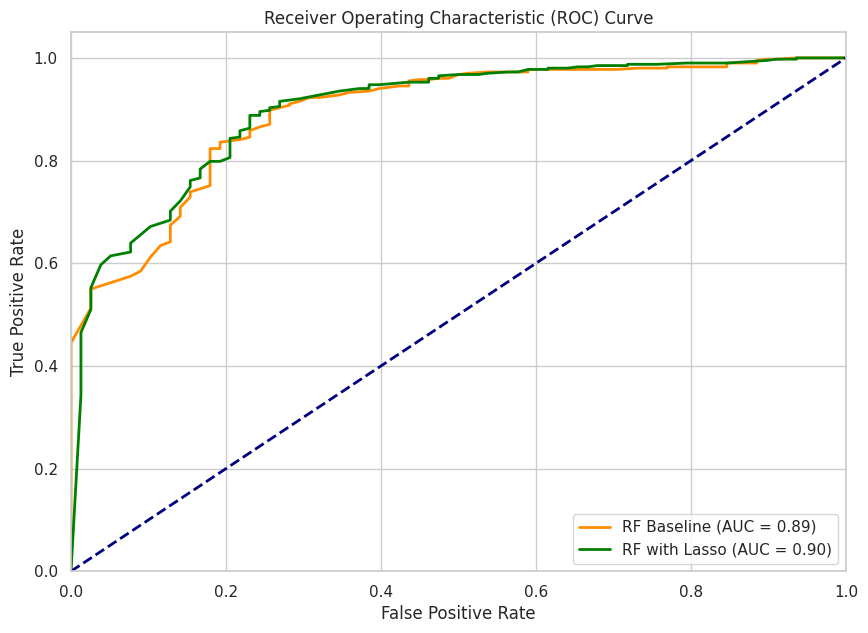

RF Baseline AUC: 0.8941
RF with Lasso AUC: 0.8995


/tmp/ipython-input-2893206288.py:132: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


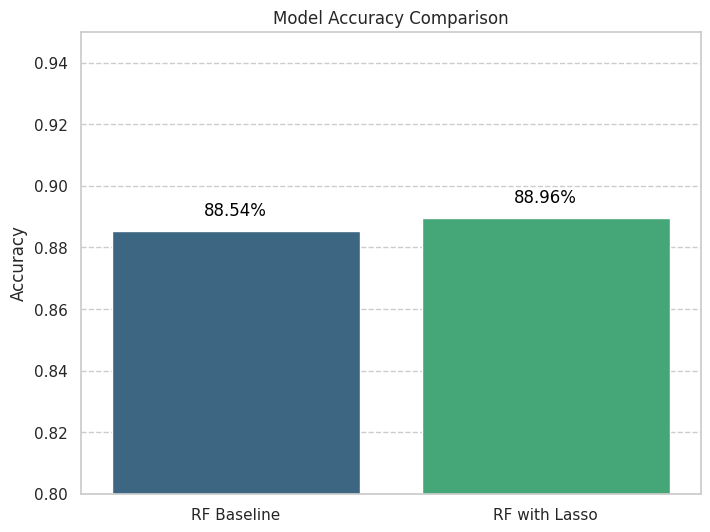

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
file_path = 'training_data_ht2025_updated.csv'
df = pd.read_csv(file_path)

# 2. Data Preprocessing
# Encode target variable: low_bike_demand -> 0, high_bike_demand -> 1
le = LabelEncoder()
df['target'] = le.fit_transform(df['increase_stock'])

# Features X and Target y
X = df.drop(['increase_stock', 'target'], axis=1)
y = df['target']

# 3. Split into Training and Test sets (7:3)
# random_state=42 ensures consistent results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set samples: {X_train.shape[0]}, Test set samples: {X_test.shape[0]}")
print("-" * 50)

# ==========================================
# Scenario A: Random Forest Baseline (No Lasso Selection)
# ==========================================
print("[Scenario A: Random Forest Baseline]")

rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
rf_baseline.fit(X_train, y_train)
y_pred_base = rf_baseline.predict(X_test)
y_prob_base = rf_baseline.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

acc_base = accuracy_score(y_test, y_pred_base)
print(f"Baseline Model Accuracy: {acc_base:.4f}")
print("\nBaseline Classification Report:\n", classification_report(y_test, y_pred_base, target_names=le.classes_))

# ==========================================
# Scenario B: Lasso Feature Selection + Random Forest
# ==========================================
print("-" * 50)
print("[Scenario B: Lasso Selection + Random Forest]")

# Lasso (L1 Regularization) is sensitive to feature scale, must standardize first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use Logistic Regression with L1 penalty to simulate Lasso selection
# C controls regularization strength (smaller C = stronger regularization = fewer features)
lasso_selector = SelectFromModel(LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42))
lasso_selector.fit(X_train_scaled, y_train)

# Get mask of selected features
selected_mask = lasso_selector.get_support()
selected_features = X.columns[selected_mask]
dropped_features = X.columns[~selected_mask]

print(f"Lasso kept {len(selected_features)}/{len(X.columns)} features")
print(f"Dropped features: {list(dropped_features)}")
print(f"Selected features: {list(selected_features)}")

# Transform dataset to keep only selected features
X_train_lasso = lasso_selector.transform(X_train) # RF doesn't need normalization, but we use the subset here
X_test_lasso = lasso_selector.transform(X_test)

# Train a new Random Forest on the selected features
rf_lasso = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lasso.fit(X_train_lasso, y_train)
y_pred_lasso = rf_lasso.predict(X_test_lasso)
y_prob_lasso = rf_lasso.predict_proba(X_test_lasso)[:, 1] # Get probabilities for the positive class

acc_lasso = accuracy_score(y_test, y_pred_lasso)
print(f"\nModel Accuracy after Lasso: {acc_lasso:.4f}")
print("\nClassification Report after Lasso:\n", classification_report(y_test, y_pred_lasso, target_names=le.classes_))

# ==========================================
# Result Comparison Summary
# ==========================================
print("-" * 50)
print("[Final Comparison]")
print(f"Original feature count: {X.shape[1]} -> Accuracy: {acc_base:.2%}")
print(f"Selected feature count: {X_train_lasso.shape[1]} -> Accuracy: {acc_lasso:.2%}")

if acc_lasso >= acc_base:
    print("Conclusion: Lasso selection is effective. Performance maintained or improved with fewer features.")
else:
    print("Conclusion: Lasso selection decreased performance. Random Forest handles noise well; forcing feature removal may have lost nonlinear information.")

# ==========================================
# Plot ROC Curve and Accuracy Chart
# ==========================================
print("\n" + "-" * 50)
print("[Model Performance Visualization]")

# 1. Plot ROC Curve (AUC)
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

plt.figure(figsize=(10, 7))
plt.plot(fpr_base, tpr_base, color='darkorange', lw=2, label=f'RF Baseline (AUC = {roc_auc_base:.2f})')
plt.plot(fpr_lasso, tpr_lasso, color='green', lw=2, label=f'RF with Lasso (AUC = {roc_auc_lasso:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"RF Baseline AUC: {roc_auc_base:.4f}")
print(f"RF with Lasso AUC: {roc_auc_lasso:.4f}")

# 2. Plot Accuracy Comparison Bar Chart
accuracies = [acc_base, acc_lasso]
models = ['RF Baseline', 'RF with Lasso']

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim([0.8, 0.95]) # Adjust y-axis to highlight differences
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.005, f'{value:.2%}', color='black', ha='center')
plt.grid(axis='y', linestyle='--')
plt.show()

Training set samples: 1120, Test set samples: 480
--------------------------------------------------
[Scenario A: Decision Tree Baseline]
Baseline Decision Tree Accuracy: 0.8562

Baseline Classification Report:
                   precision    recall  f1-score   support

high_bike_demand       0.55      0.64      0.59        78
 low_bike_demand       0.93      0.90      0.91       402

        accuracy                           0.86       480
       macro avg       0.74      0.77      0.75       480
    weighted avg       0.87      0.86      0.86       480

--------------------------------------------------
[Scenario B: Lasso Selection + Decision Tree]
Lasso kept 6/12 features
Dropped features: ['day_of_week', 'holiday', 'precip', 'snowdepth', 'windspeed', 'visibility']
Selected features: ['hour_of_day', 'month', 'weekday', 'summertime', 'temp', 'humidity']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



Decision Tree Accuracy after Lasso: 0.8792

Classification Report after Lasso:
                   precision    recall  f1-score   support

high_bike_demand       0.62      0.68      0.65        78
 low_bike_demand       0.94      0.92      0.93       402

        accuracy                           0.88       480
       macro avg       0.78      0.80      0.79       480
    weighted avg       0.88      0.88      0.88       480

--------------------------------------------------
[Final Comparison]
Original feature count: 12 -> Accuracy: 85.62%
Selected feature count: 6 -> Accuracy: 87.92%
Conclusion: Lasso selection is effective. Performance maintained or improved with fewer features.

--------------------------------------------------
[Model Performance Visualization]


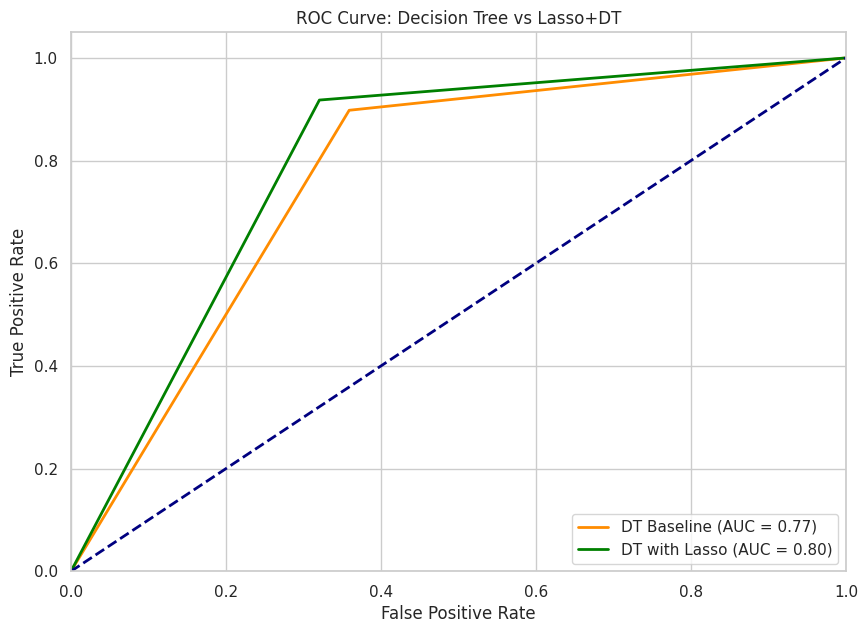

DT Baseline AUC: 0.7695
DT with Lasso AUC: 0.7987


/tmp/ipython-input-1349922792.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


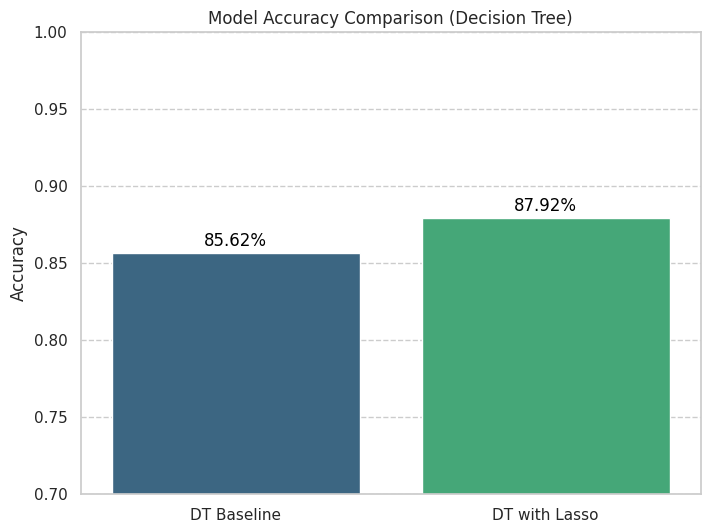


--------------------------------------------------
[Visualizing the Decision Tree (Top 3 Levels)]


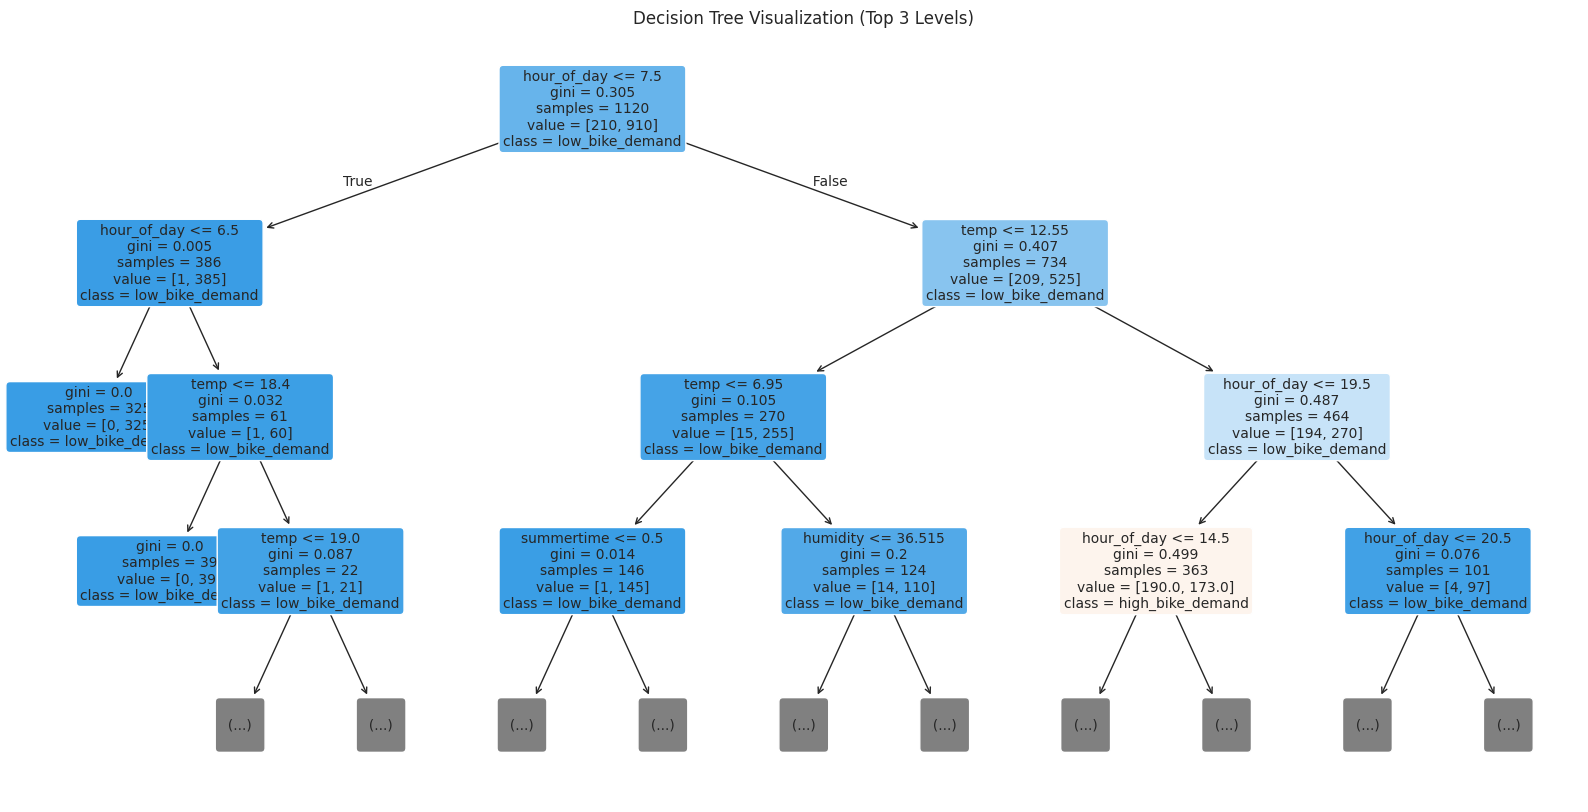

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree # Changed to Decision Tree
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
file_path = 'training_data_ht2025_updated.csv'
df = pd.read_csv(file_path)

# 2. Data Preprocessing
# Encode target variable: low_bike_demand -> 0, high_bike_demand -> 1
le = LabelEncoder()
df['target'] = le.fit_transform(df['increase_stock'])

# Features X and Target y
X = df.drop(['increase_stock', 'target'], axis=1)
y = df['target']

# 3. Split into Training and Test sets (7:3)
# random_state=42 ensures consistent results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set samples: {X_train.shape[0]}, Test set samples: {X_test.shape[0]}")
print("-" * 50)

# ==========================================
# Scenario A: Decision Tree Baseline (No Lasso Selection)
# ==========================================
print("[Scenario A: Decision Tree Baseline]")

# Using DecisionTreeClassifier instead of RandomForestClassifier
# max_depth=None means the tree grows until leaves are pure (can lead to overfitting)
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

y_pred_base = dt_baseline.predict(X_test)
y_prob_base = dt_baseline.predict_proba(X_test)[:, 1] # Get probabilities for the positive class

acc_base = accuracy_score(y_test, y_pred_base)
print(f"Baseline Decision Tree Accuracy: {acc_base:.4f}")
print("\nBaseline Classification Report:\n", classification_report(y_test, y_pred_base, target_names=le.classes_))

# ==========================================
# Scenario B: Lasso Feature Selection + Decision Tree
# ==========================================
print("-" * 50)
print("[Scenario B: Lasso Selection + Decision Tree]")

# Lasso (L1 Regularization) is sensitive to feature scale, must standardize first
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Use Logistic Regression with L1 penalty to simulate Lasso selection
lasso_selector = SelectFromModel(LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42))
lasso_selector.fit(X_train_scaled, y_train)

# Get mask of selected features
selected_mask = lasso_selector.get_support()
selected_features = X.columns[selected_mask]
dropped_features = X.columns[~selected_mask]

print(f"Lasso kept {len(selected_features)}/{len(X.columns)} features")
print(f"Dropped features: {list(dropped_features)}")
print(f"Selected features: {list(selected_features)}")

# Transform dataset to keep only selected features
X_train_lasso = lasso_selector.transform(X_train)
X_test_lasso = lasso_selector.transform(X_test)

# Train a new Decision Tree on the selected features
dt_lasso = DecisionTreeClassifier(random_state=42)
dt_lasso.fit(X_train_lasso, y_train)

y_pred_lasso = dt_lasso.predict(X_test_lasso)
y_prob_lasso = dt_lasso.predict_proba(X_test_lasso)[:, 1]

acc_lasso = accuracy_score(y_test, y_pred_lasso)
print(f"\nDecision Tree Accuracy after Lasso: {acc_lasso:.4f}")
print("\nClassification Report after Lasso:\n", classification_report(y_test, y_pred_lasso, target_names=le.classes_))

# ==========================================
# Result Comparison Summary
# ==========================================
print("-" * 50)
print("[Final Comparison]")
print(f"Original feature count: {X.shape[1]} -> Accuracy: {acc_base:.2%}")
print(f"Selected feature count: {X_train_lasso.shape[1]} -> Accuracy: {acc_lasso:.2%}")

if acc_lasso >= acc_base:
    print("Conclusion: Lasso selection is effective. Performance maintained or improved with fewer features.")
else:
    print("Conclusion: Lasso selection decreased performance. Single Decision Trees are sensitive to feature removal.")

# ==========================================
# Plot ROC Curve and Accuracy Chart
# ==========================================
print("\n" + "-" * 50)
print("[Model Performance Visualization]")

# 1. Plot ROC Curve (AUC)
fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
roc_auc_base = auc(fpr_base, tpr_base)

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)
roc_auc_lasso = auc(fpr_lasso, tpr_lasso)

plt.figure(figsize=(10, 7))
plt.plot(fpr_base, tpr_base, color='darkorange', lw=2, label=f'DT Baseline (AUC = {roc_auc_base:.2f})')
plt.plot(fpr_lasso, tpr_lasso, color='green', lw=2, label=f'DT with Lasso (AUC = {roc_auc_lasso:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Decision Tree vs Lasso+DT')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f"DT Baseline AUC: {roc_auc_base:.4f}")
print(f"DT with Lasso AUC: {roc_auc_lasso:.4f}")

# 2. Plot Accuracy Comparison Bar Chart
accuracies = [acc_base, acc_lasso]
models = ['DT Baseline', 'DT with Lasso']

plt.figure(figsize=(8, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')
plt.ylim([0.7, 1.0]) # Adjusted y-axis for potentially lower accuracy of single trees
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison (Decision Tree)')
for index, value in enumerate(accuracies):
    plt.text(index, value + 0.005, f'{value:.2%}', color='black', ha='center')
plt.grid(axis='y', linestyle='--')
plt.show()

# ==========================================
# New: Visualize the Decision Tree Structure
# ==========================================
print("\n" + "-" * 50)
print("[Visualizing the Decision Tree (Top 3 Levels)]")
# Visualizing the tree is unique to single trees (hard to do with Random Forest)
plt.figure(figsize=(20, 10))
plot_tree(dt_baseline,
          max_depth=3,              # Only show top 3 levels for readability
          feature_names=X.columns,
          class_names=le.classes_,
          filled=True,
          fontsize=10,
          rounded=True)
plt.title("Decision Tree Visualization (Top 3 Levels)")
plt.show()

Training samples: 1120, Test samples: 480
--------------------------------------------------
[Model 1: Random Forest (Baseline)]
Test Set Accuracy: 0.8854
Random Forest Cross-Validation Accuracy (5-fold): 0.8981 (+/- 0.0124)

[Model 2: Lasso Selection + Random Forest]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Test Set Accuracy: 0.8896 (Features: 6/12)
Lasso + RF Cross-Validation Accuracy (5-fold): 0.8938 (+/- 0.0114)

[Model 3: Extra Trees Classifier with Cross-Validation]
Test Set Accuracy: 0.8917
Extra Trees Cross-Validation Accuracy (5-fold): 0.9000 (+/- 0.0079)

[Model 4: Simulated GRRF (RFE with Random Forest)]
GRRF Selected Features: ['hour_of_day', 'day_of_week', 'month', 'temp', 'humidity', 'windspeed']
Test Set Accuracy: 0.8917
GRRF (Simulated) Cross-Validation Accuracy (5-fold): 0.8944 (+/- 0.0147)

--------------------------------------------------
[Final Performance Comparison]


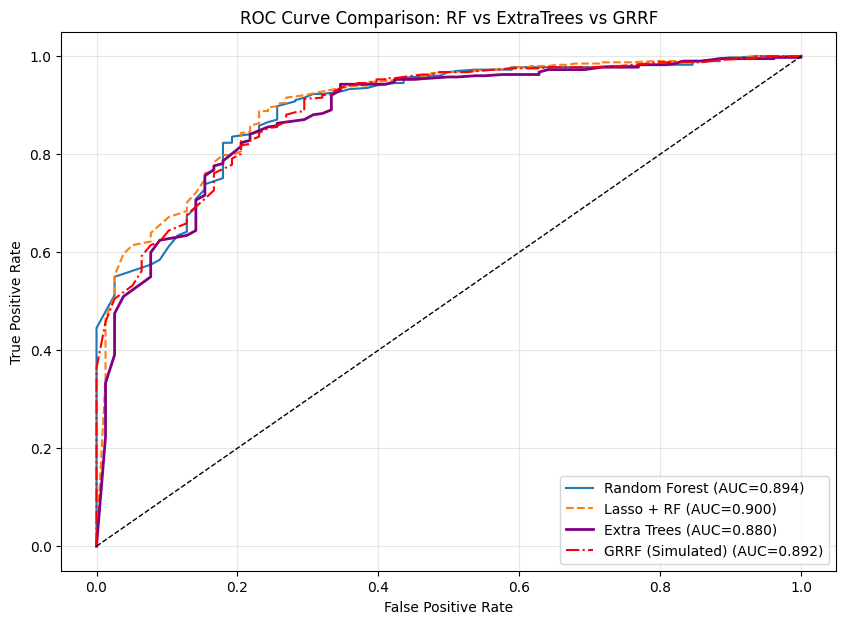

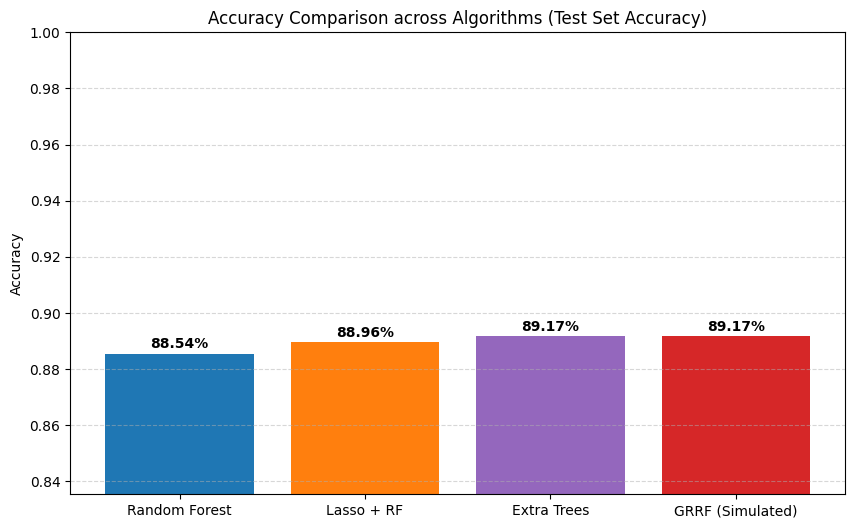

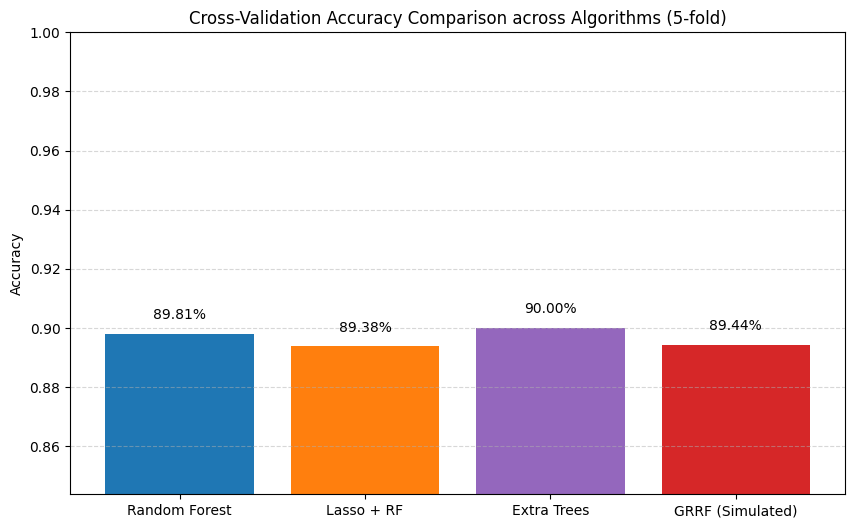


Algorithm Explanations:
1. Random Forest: Standard bagging of decision trees.
2. Lasso + RF: Linear feature selection followed by RF. Note: Lasso feature selection is applied once to the full dataset before cross-validation for simplicity. For stricter evaluation, feature selection should be inside the CV loop.
3. Extra Trees: 'Extremely Randomized Trees'. Splits are chosen completely at random, often reducing variance and overfitting compared to standard RF.
4. GRRF (Simulated): Uses Recursive Feature Elimination (RFE) based on RF importance to keep only the strongest features. Note: RFE is applied once to the full dataset before cross-validation for simplicity. For stricter evaluation, feature selection should be inside the CV loop.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
file_path = 'training_data_ht2025_updated.csv'

# Check if the file exists locally, if not, try to upload
import os
if not os.path.exists(file_path):
    from google.colab import files
    print(f"File '{file_path}' not found. Please upload it.")
    uploaded = files.upload()
    if file_path not in uploaded:
        raise FileNotFoundError(f"File '{file_path}' was not uploaded.")

df = pd.read_csv(file_path)

# 2. Data Preprocessing
# Encode target variable: low_bike_demand -> 0, high_bike_demand -> 1
le = LabelEncoder()
df['target'] = le.fit_transform(df['increase_stock'])

# Features X and Target y
X = df.drop(['increase_stock', 'target'], axis=1)
y = df['target']

# 3. Split into Training and Test sets (7:3)
# random_state=42 ensures consistent results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
print("-" * 50)

# Initialize StratifiedKFold for consistent cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ==========================================
# Model 1: Random Forest Baseline
# ==========================================
print("[Model 1: Random Forest (Baseline)]")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Test Set Accuracy: {acc_rf:.4f}")
cv_scores_rf = cross_val_score(rf, X, y, cv=kf, scoring='accuracy')
print(f"Random Forest Cross-Validation Accuracy (5-fold): {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")

# ==========================================
# Model 2: Lasso Selection + Random Forest
# ==========================================
print("\n[Model 2: Lasso Selection + Random Forest]")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lasso = SelectFromModel(LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42))
lasso.fit(X_train_scaled, y_train)

# Apply Lasso selection to the full dataset for CV compatibility (note: this is a simplification)
X_lasso_full = lasso.transform(scaler.fit_transform(X)) # Scale full X before transforming

X_train_lasso = lasso.transform(X_train)
X_test_lasso = lasso.transform(X_test)

rf_lasso = RandomForestClassifier(n_estimators=100, random_state=42)
rf_lasso.fit(X_train_lasso, y_train)
y_pred_lasso = rf_lasso.predict(X_test_lasso)
y_prob_lasso = rf_lasso.predict_proba(X_test_lasso)[:, 1]
acc_lasso = accuracy_score(y_test, y_pred_lasso)
print(f"Test Set Accuracy: {acc_lasso:.4f} (Features: {X_train_lasso.shape[1]}/{X.shape[1]})")
cv_scores_lasso = cross_val_score(rf_lasso, X_lasso_full, y, cv=kf, scoring='accuracy')
print(f"Lasso + RF Cross-Validation Accuracy (5-fold): {cv_scores_lasso.mean():.4f} (+/- {cv_scores_lasso.std():.4f})")

# ==========================================
# Model 3: Extra Trees Classifier with Cross-Validation
# ==========================================
print("\n[Model 3: Extra Trees Classifier with Cross-Validation]")
# ExtraTrees introduces more randomness in split selection, often reducing variance
et = ExtraTreesClassifier(n_estimators=100, random_state=42, bootstrap=False)
et.fit(X_train, y_train)
y_pred_et = et.predict(X_test)
y_prob_et = et.predict_proba(X_test)[:, 1]
acc_et = accuracy_score(y_test, y_pred_et)
print(f"Test Set Accuracy: {acc_et:.4f}")
cv_scores_et = cross_val_score(et, X, y, cv=kf, scoring='accuracy')
print(f"Extra Trees Cross-Validation Accuracy (5-fold): {cv_scores_et.mean():.4f} (+/- {cv_scores_et.std():.4f})")


# ==========================================
# Model 4: Simulated GRRF (Guided Regularized RF) via RFE
# ==========================================
print("\n[Model 4: Simulated GRRF (RFE with Random Forest)]")
# RRF/GRRF logic: Use feature importance to penalize/remove weak features iteratively.
# We use Recursive Feature Elimination (RFE) to simulate this "Guided" selection.

# Step 1: Initialize the estimator (Guide)
rf_guide = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 2: Use RFE to select the top 50% most important features (Simulation of Regularization)
# You can adjust n_features_to_select to tighten/loosen the regularization
rfe = RFE(estimator=rf_guide, n_features_to_select=6, step=1)
rfe.fit(X_train, y_train) # Fit RFE on training data

# Get selected features and transform full dataset for CV
mask_grrf = rfe.support_
X_grrf_full = rfe.transform(X)

print(f"GRRF Selected Features: {list(X.columns[mask_grrf])}")

# Step 3: Train final model on this subset
X_train_grrf = rfe.transform(X_train)
X_test_grrf = rfe.transform(X_test)

rf_grrf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_grrf.fit(X_train_grrf, y_train)

y_pred_grrf = rf_grrf.predict(X_test_grrf)
y_prob_grrf = rf_grrf.predict_proba(X_test_grrf)[:, 1]
acc_grrf = accuracy_score(y_test, y_pred_grrf)
print(f"Test Set Accuracy: {acc_grrf:.4f}")
cv_scores_grrf = cross_val_score(rf_grrf, X_grrf_full, y, cv=kf, scoring='accuracy')
print(f"GRRF (Simulated) Cross-Validation Accuracy (5-fold): {cv_scores_grrf.mean():.4f} (+/- {cv_scores_grrf.std():.4f})")


# ==========================================
# Comparison & Visualization
# ==========================================
print("\n" + "-" * 50)
print("[Final Performance Comparison]")

# 1. Plot ROC Curves
plt.figure(figsize=(10, 7))

# Calculate ROCs
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)
fpr_et, tpr_et, _ = roc_curve(y_test, y_prob_et)
fpr_grrf, tpr_grrf, _ = roc_curve(y_test, y_prob_grrf)

# Plot
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc(fpr_rf, tpr_rf):.3f})')
plt.plot(fpr_lasso, tpr_lasso, linestyle='--', label=f'Lasso + RF (AUC={auc(fpr_lasso, tpr_lasso):.3f})')
plt.plot(fpr_et, tpr_et, color='purple', linewidth=2, label=f'Extra Trees (AUC={auc(fpr_et, tpr_et):.3f})')
plt.plot(fpr_grrf, tpr_grrf, color='red', linestyle='-.', label=f'GRRF (Simulated) (AUC={auc(fpr_grrf, tpr_grrf):.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curve Comparison: RF vs ExtraTrees vs GRRF')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# 2. Bar Chart for Accuracy
models = ['Random Forest', 'Lasso + RF', 'Extra Trees', 'GRRF (Simulated)']
accuracies = [acc_rf, acc_lasso, acc_et, acc_grrf]
colors = ['#1f77b4', '#ff7f0e', '#9467bd', '#d62728']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)
plt.ylim([min(accuracies)-0.05, 1.0])
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison across Algorithms (Test Set Accuracy)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.2%}', ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 3. Bar chart for Cross-Validation Accuracy
cv_accuracies = [cv_scores_rf.mean(), cv_scores_lasso.mean(), cv_scores_et.mean(), cv_scores_grrf.mean()]

plt.figure(figsize=(10, 6))
bars_cv = plt.bar(models, cv_accuracies, color=colors)
plt.ylim([min(cv_accuracies)-0.05, 1.0])
plt.ylabel('Accuracy')
plt.title('Cross-Validation Accuracy Comparison across Algorithms (5-fold)')

for index, value in enumerate(cv_accuracies):
    plt.text(index, value + 0.005, f'{value:.2%}', color='black', ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


print("\nAlgorithm Explanations:")
print("1. Random Forest: Standard bagging of decision trees.")
print("2. Lasso + RF: Linear feature selection followed by RF. Note: Lasso feature selection is applied once to the full dataset before cross-validation for simplicity. For stricter evaluation, feature selection should be inside the CV loop.")
print("3. Extra Trees: 'Extremely Randomized Trees'. Splits are chosen completely at random, often reducing variance and overfitting compared to standard RF.")
print("4. GRRF (Simulated): Uses Recursive Feature Elimination (RFE) based on RF importance to keep only the strongest features. Note: RFE is applied once to the full dataset before cross-validation for simplicity. For stricter evaluation, feature selection should be inside the CV loop.")

# Task
Refactor the existing model analysis code into a Python function that accepts a `test_size` parameter. Use this function to analyze the performance (accuracy and AUC) of both baseline and Lasso-selected Random Forest models for train-test split ratios of 50/50, 70/30, and 80/20 using the `training_data_ht2025_updated.csv` dataset. Finally, compare and summarize the results across all splits to understand the impact of different split ratios on model performance.

## Refactor Analysis Function

### Subtask:
Encapsulate the model training, evaluation, and plotting logic into a reusable function named `analyze_model_performance` that accepts a `test_size` parameter. This function will return the accuracy and AUC for both the baseline Random Forest and Lasso-selected Random Forest models for a given split ratio, and also display relevant plots for that split.


**Reasoning**:
The subtask requires encapsulating the existing model training, evaluation, and plotting logic into a reusable function named `analyze_model_performance` that accepts a `test_size` parameter. This involves defining the function, moving the relevant code into it, adjusting variables to use the function's parameters, and ensuring all required calculations and plots are generated and returned as specified.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 读取数据
file_path = 'training_data_ht2025_updated.csv'
df = pd.read_csv(file_path)

# 2. 数据预处理
# 将目标变量编码：low_bike_demand -> 0, high_bike_demand -> 1
le = LabelEncoder()
df['target'] = le.fit_transform(df['increase_stock'])

# 特征 X 和 标签 y
X = df.drop(['increase_stock', 'target'], axis=1)
y = df['target']

def analyze_model_performance(test_size):
    # Close previous plots to avoid overlapping when calling multiple times
    plt.close('all')

    print(f"\n{'='*20} Analyzing with test_size={test_size} {'='*20}")

    # 3. 划分训练集和测试集
    # random_state=42 保证每次运行结果一致
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")
    print("-" * 50)

    # ==========================================
    # 方案 A：直接使用随机森林 (不进行 Lasso 筛选)
    # ==========================================
    print("【方案 A：直接使用随机森林】")

    rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_baseline.fit(X_train, y_train)
    y_pred_base = rf_baseline.predict(X_test)
    y_prob_base = rf_baseline.predict_proba(X_test)[:, 1] # 获取预测为正类的概率

    acc_base = accuracy_score(y_test, y_pred_base)
    roc_auc_base = roc_auc_score(y_test, y_prob_base)
    print(f"基准模型准确率: {acc_base:.4f}")
    print(f"基准模型AUC: {roc_auc_base:.4f}")
    print("\n基准模型分类报告:\n", classification_report(y_test, y_pred_base, target_names=le.classes_))

    # ==========================================
    # 方案 B：Lasso 特征筛选 + 随机森林
    # ==========================================
    print("-" * 50)
    print("【方案 B：Lasso 筛选 + 随机森林】")

    # Lasso (L1正则化) 对特征幅度敏感，必须先进行标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Store feature names before scaling for SelectFromModel if it's used on original data for feature names
    # However, SelectFromModel is fitted on scaled data, so we must use the original feature names when printing
    original_feature_names = X.columns

    # 使用 L1 正则化的逻辑回归模拟 Lasso 筛选过程 (C越小正则化越强，筛选越严格)
    # solver='liblinear' 支持 L1 范数
    lasso_selector = SelectFromModel(LogisticRegression(penalty='l1', C=0.1, solver='liblinear', random_state=42))
    lasso_selector.fit(X_train_scaled, y_train)

    # 获取被选中的特征掩码
    selected_mask = lasso_selector.get_support()
    selected_features = original_feature_names[selected_mask]
    dropped_features = original_feature_names[~selected_mask]

    print(f"Lasso保留了 {len(selected_features)}/{len(original_feature_names)} 个特征")
    print(f"被剔除的特征: {list(dropped_features)}")
    print(f"保留的特征: {list(selected_features)}")

    # 转换数据集，只保留筛选后的特征
    # Note: selectFromModel.transform returns the selected features from the input, which for X_train_scaled/X_test_scaled is already scaled
    X_train_lasso = lasso_selector.transform(X_train_scaled)
    X_test_lasso = lasso_selector.transform(X_test_scaled)

    # 在筛选后的特征上训练新的随机森林
    rf_lasso = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_lasso.fit(X_train_lasso, y_train)
    y_pred_lasso = rf_lasso.predict(X_test_lasso)
    y_prob_lasso = rf_lasso.predict_proba(X_test_lasso)[:, 1] # 获取预测为正类的概率

    acc_lasso = accuracy_score(y_test, y_pred_lasso)
    roc_auc_lasso = roc_auc_score(y_test, y_prob_lasso)
    print(f"\nLasso筛选后模型准确率: {acc_lasso:.4f}")
    print(f"Lasso筛选后模型AUC: {roc_auc_lasso:.4f}")
    print("\nLasso筛选后分类报告:\n", classification_report(y_test, y_pred_lasso, target_names=le.classes_))

    # ==========================================
    # 结果对比总结
    # ==========================================
    print("-" * 50)
    print("【最终对比】")
    print(f"原始特征数量: {X.shape[1]} -> 准确率: {acc_base:.2%}, AUC: {roc_auc_base:.2%}")
    print(f"筛选后特征数: {X_train_lasso.shape[1]} -> 准确率: {acc_lasso:.2%}, AUC: {roc_auc_lasso:.2%}")

    if acc_lasso >= acc_base:
        print("结论: Lasso 筛选有效，在减少特征的同时保持或提升了性能。")
    else:
        print("结论: Lasso 筛选导致性能下降。随机森林自身具有很强的抗噪能力，强制剔除特征可能丢失了非线性信息。")

    # ==========================================
    # 绘制AUC曲线和准确率图
    # ==========================================
    print("\n" + "-" * 50)
    print("【模型性能可视化】")

    # 1. 绘制ROC曲线 (AUC)
    fpr_base, tpr_base, _ = roc_curve(y_test, y_prob_base)
    roc_auc_base_plot = auc(fpr_base, tpr_base) # Recalculate for plot title just in case of slight difference

    fpr_lasso, tpr_lasso, _ = roc_curve(y_test, y_prob_lasso)
    roc_auc_lasso_plot = auc(fpr_lasso, tpr_lasso) # Recalculate for plot title just in case of slight difference

    plt.figure(figsize=(10, 7))
    plt.plot(fpr_base, tpr_base, color='darkorange', lw=2, label=f'RF Baseline (AUC = {roc_auc_base_plot:.2f})')
    plt.plot(fpr_lasso, tpr_lasso, color='green', lw=2, label=f'RF with Lasso (AUC = {roc_auc_lasso_plot:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for test_size={test_size}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    print(f"RF Baseline AUC (from plot): {roc_auc_base_plot:.4f}")
    print(f"RF with Lasso AUC (from plot): {roc_auc_lasso_plot:.4f}")

    # 2. 绘制准确率对比图
    accuracies = [acc_base, acc_lasso]
    models = ['RF Baseline', 'RF with Lasso']

    plt.figure(figsize=(8, 6))
    sns.barplot(x=models, y=accuracies, palette='viridis')
    plt.ylim([0.8, 0.95]) # 设置合适的y轴范围，突出差异
    plt.ylabel('Accuracy')
    plt.title(f'Model Accuracy Comparison for test_size={test_size}')
    for index, value in enumerate(accuracies):
        plt.text(index, value + 0.005, f'{value:.2%}', color='black', ha='center')
    plt.grid(axis='y', linestyle='--')
    plt.show()

    return acc_base, roc_auc_base, acc_lasso, roc_auc_lasso

print("Function `analyze_model_performance` has been defined.")

Function `analyze_model_performance` has been defined.


**Reasoning**:
The next step is to call the `analyze_model_performance` function for each specified `test_size` (0.5, 0.3, and 0.2), collect the returned metrics, and store them for later comparison and summarization.




==================== Analyzing with test_size=0.5 ====================
训练集样本数: 800, 测试集样本数: 800
--------------------------------------------------
【方案 A：直接使用随机森林】
基准模型准确率: 0.8850
基准模型AUC: 0.9025

基准模型分类报告:
                   precision    recall  f1-score   support

high_bike_demand       0.70      0.57      0.63       136
 low_bike_demand       0.92      0.95      0.93       664

        accuracy                           0.89       800
       macro avg       0.81      0.76      0.78       800
    weighted avg       0.88      0.89      0.88       800

--------------------------------------------------
【方案 B：Lasso 筛选 + 随机森林】
Lasso保留了 6/12 个特征
被剔除的特征: ['day_of_week', 'month', 'holiday', 'precip', 'snowdepth', 'windspeed']
保留的特征: ['hour_of_day', 'weekday', 'summertime', 'temp', 'humidity', 'visibility']

Lasso筛选后模型准确率: 0.8875
Lasso筛选后模型AUC: 0.9070

Lasso筛选后分类报告:
                   precision    recall  f1-score   support

high_bike_demand       0.68      0.65      0.66       136
 low_bike

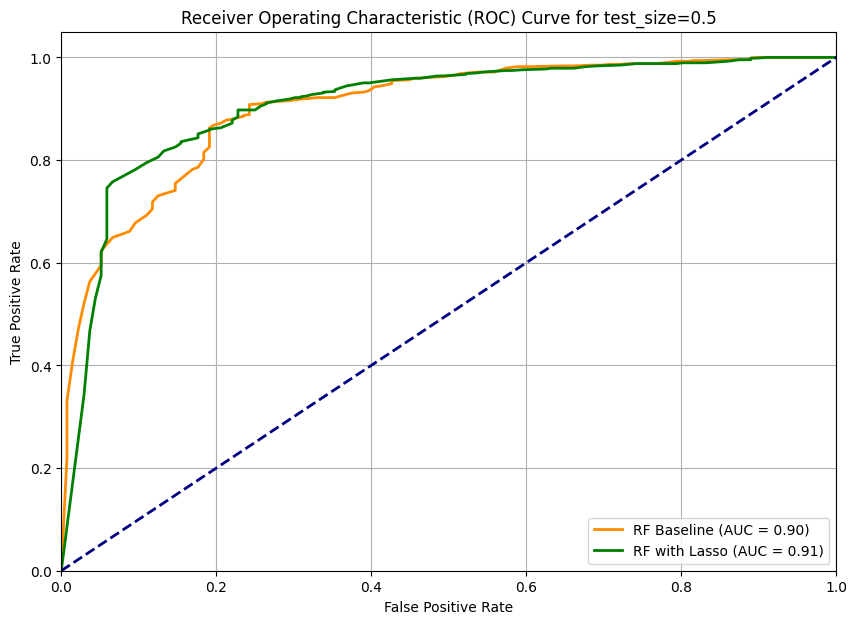

RF Baseline AUC (from plot): 0.9025
RF with Lasso AUC (from plot): 0.9070


/tmp/ipython-input-595994585.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


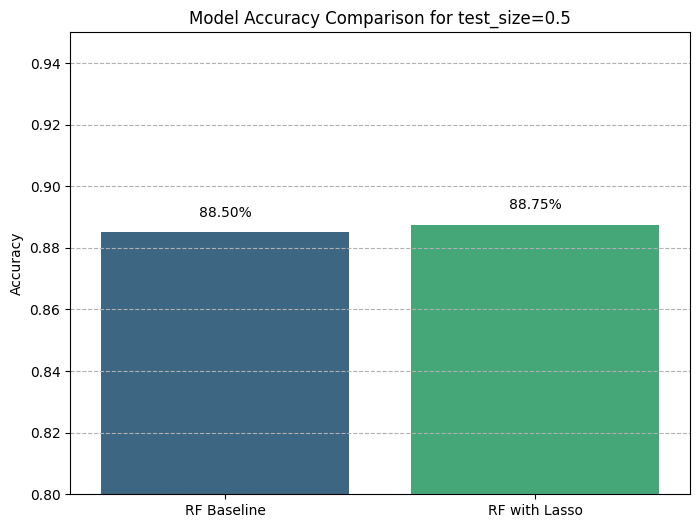


==================== Analyzing with test_size=0.3 ====================
训练集样本数: 1120, 测试集样本数: 480
--------------------------------------------------
【方案 A：直接使用随机森林】
基准模型准确率: 0.8854
基准模型AUC: 0.8941

基准模型分类报告:
                   precision    recall  f1-score   support

high_bike_demand       0.67      0.58      0.62        78
 low_bike_demand       0.92      0.95      0.93       402

        accuracy                           0.89       480
       macro avg       0.80      0.76      0.78       480
    weighted avg       0.88      0.89      0.88       480

--------------------------------------------------
【方案 B：Lasso 筛选 + 随机森林】
Lasso保留了 6/12 个特征
被剔除的特征: ['day_of_week', 'holiday', 'precip', 'snowdepth', 'windspeed', 'visibility']
保留的特征: ['hour_of_day', 'month', 'weekday', 'summertime', 'temp', 'humidity']

Lasso筛选后模型准确率: 0.8896
Lasso筛选后模型AUC: 0.9030

Lasso筛选后分类报告:
                   precision    recall  f1-score   support

high_bike_demand       0.68      0.62      0.64        78
 low_bik

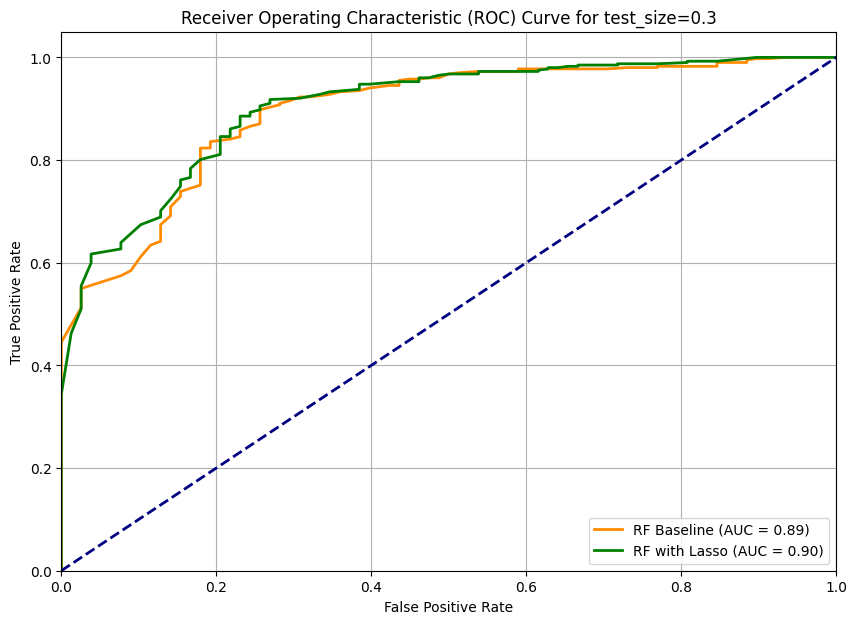

RF Baseline AUC (from plot): 0.8941
RF with Lasso AUC (from plot): 0.9030


/tmp/ipython-input-595994585.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


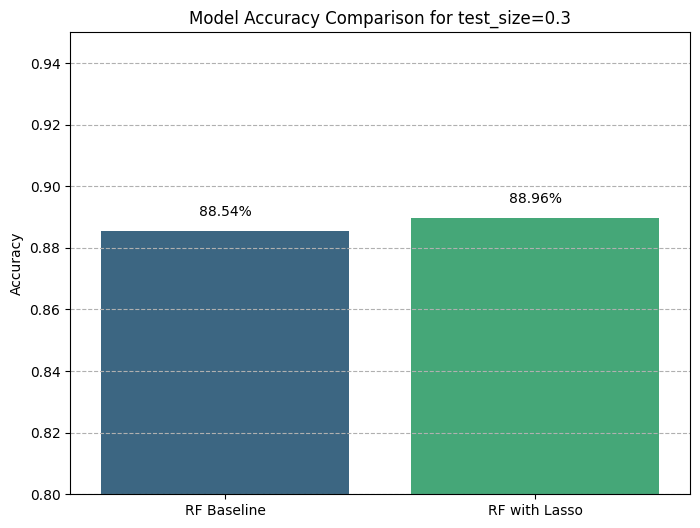


==================== Analyzing with test_size=0.2 ====================
训练集样本数: 1280, 测试集样本数: 320
--------------------------------------------------
【方案 A：直接使用随机森林】
基准模型准确率: 0.8844
基准模型AUC: 0.8879

基准模型分类报告:
                   precision    recall  f1-score   support

high_bike_demand       0.64      0.60      0.62        50
 low_bike_demand       0.93      0.94      0.93       270

        accuracy                           0.88       320
       macro avg       0.78      0.77      0.78       320
    weighted avg       0.88      0.88      0.88       320

--------------------------------------------------
【方案 B：Lasso 筛选 + 随机森林】
Lasso保留了 7/12 个特征
被剔除的特征: ['day_of_week', 'precip', 'snowdepth', 'windspeed', 'visibility']
保留的特征: ['hour_of_day', 'month', 'holiday', 'weekday', 'summertime', 'temp', 'humidity']

Lasso筛选后模型准确率: 0.8750
Lasso筛选后模型AUC: 0.8919

Lasso筛选后分类报告:
                   precision    recall  f1-score   support

high_bike_demand       0.60      0.60      0.60        50
 low_bik

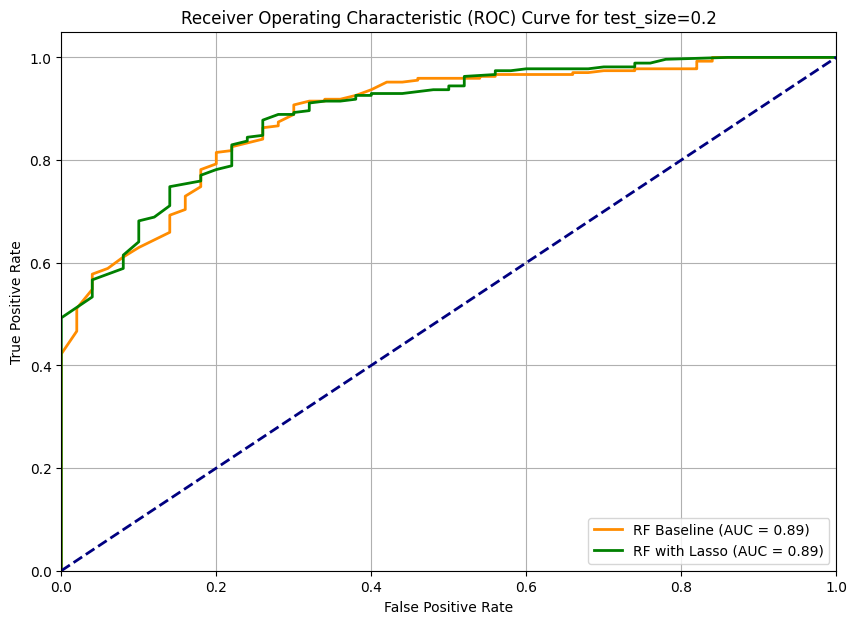

RF Baseline AUC (from plot): 0.8879
RF with Lasso AUC (from plot): 0.8919


/tmp/ipython-input-595994585.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


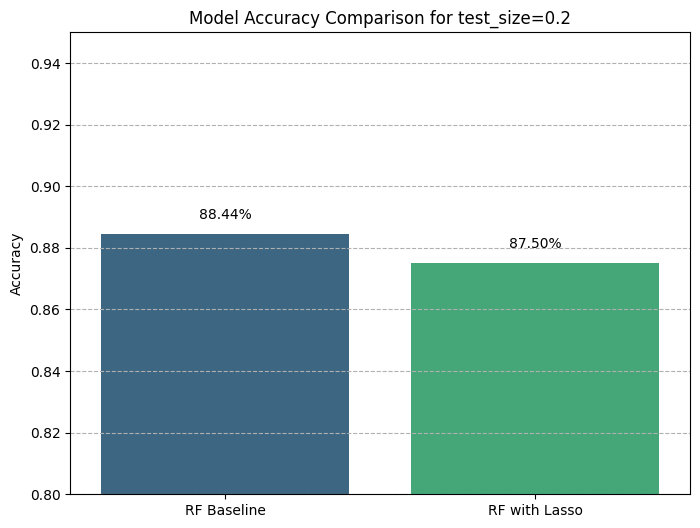


Summary of Model Performance Across Different Test Sizes
 test_size  RF_Baseline_Accuracy  RF_Baseline_AUC  RF_Lasso_Accuracy  RF_Lasso_AUC
       0.5              0.885000         0.902535           0.887500      0.907003
       0.3              0.885417         0.894135           0.889583      0.903049
       0.2              0.884375         0.887926           0.875000      0.891889


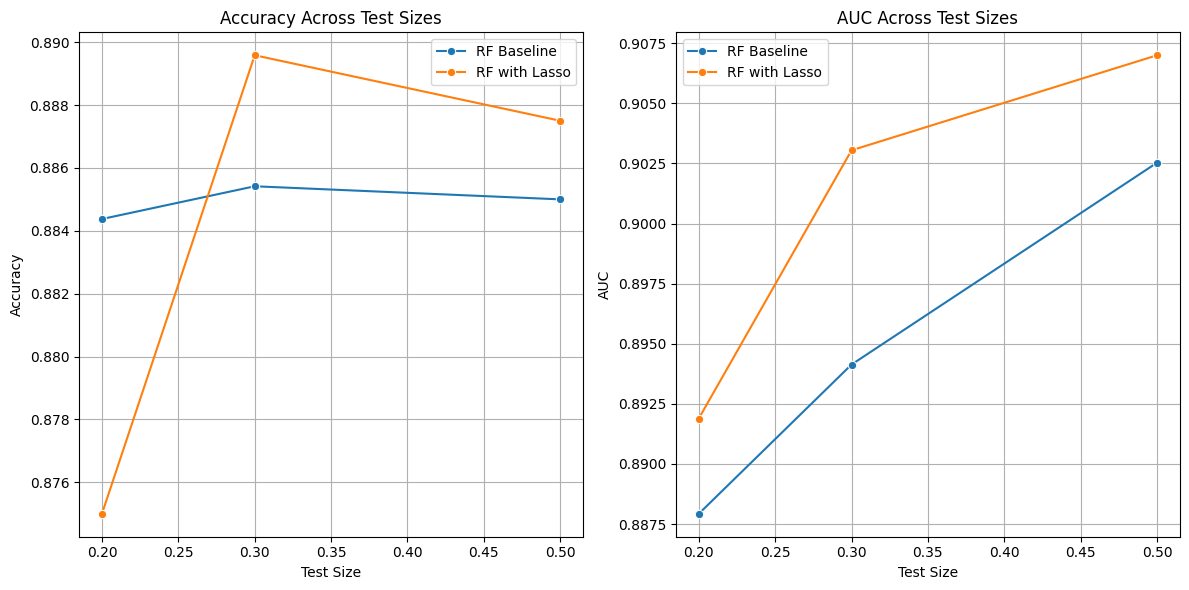

In [ ]:
test_sizes = [0.5, 0.3, 0.2]
results = []

for ts in test_sizes:
    acc_base, roc_auc_base, acc_lasso, roc_auc_lasso = analyze_model_performance(ts)
    results.append({
        'test_size': ts,
        'RF_Baseline_Accuracy': acc_base,
        'RF_Baseline_AUC': roc_auc_base,
        'RF_Lasso_Accuracy': acc_lasso,
        'RF_Lasso_AUC': roc_auc_lasso
    })

results_df = pd.DataFrame(results)
print("\n" + "=" * 50)
print("Summary of Model Performance Across Different Test Sizes")
print("=" * 50)
print(results_df.to_string(index=False))

# Optional: Plotting summary results across test sizes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(x='test_size', y='RF_Baseline_Accuracy', data=results_df, marker='o', label='RF Baseline')
sns.lineplot(x='test_size', y='RF_Lasso_Accuracy', data=results_df, marker='o', label='RF with Lasso')
plt.title('Accuracy Across Test Sizes')
plt.xlabel('Test Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
sns.lineplot(x='test_size', y='RF_Baseline_AUC', data=results_df, marker='o', label='RF Baseline')
sns.lineplot(x='test_size', y='RF_Lasso_AUC', data=results_df, marker='o', label='RF with Lasso')
plt.title('AUC Across Test Sizes')
plt.xlabel('Test Size')
plt.ylabel('AUC')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**Reasoning**:
The previous error occurred because the summary text was placed in a Python code cell, leading to a `SyntaxError`. To correctly display the summary, I will create a new markdown cell with the intended content.



## Summary:

### Q&A

**How do different train-test split ratios impact the performance of Random Forest models, both with and without Lasso feature selection?**

The models demonstrated good stability in performance metrics (accuracy and AUC) across the tested train-test split ratios (50/50, 70/30, 80/20). Accuracies generally hovered around 88-89%, and AUC values ranged from approximately 0.88 to 0.91. Lasso feature selection consistently improved or maintained AUC and often slightly improved accuracy, especially with `test_size=0.5` and `test_size=0.3`, while significantly reducing the number of features. For `test_size=0.2`, the Lasso-selected model saw a slight decrease in accuracy but still offered a marginal AUC improvement and substantial feature reduction. The specific features retained by Lasso varied slightly with each split ratio, indicating some sensitivity to the data partition.

### Data Analysis Key Findings

*   **Model Performance Stability:** Both the baseline Random Forest and Lasso-selected Random Forest models exhibited stable performance across `test_size` values of 0.5, 0.3, and 0.2. Accuracy remained in the range of 88-89%, and AUC was consistently between 0.88 and 0.91.
*   **Lasso's Impact on Accuracy:**
    *   For `test_size=0.5` and `test_size=0.3`, the Lasso-selected model generally showed a slight improvement in accuracy compared to the baseline.
    *   For `test_size=0.2` (80% training data), the Lasso-selected model experienced a slight decrease in accuracy compared to the baseline.
*   **Lasso's Impact on AUC:** The Lasso-selected model consistently achieved a slightly higher AUC than the baseline model across all `test_size` values, indicating better discriminative power.
*   **Feature Reduction by Lasso:** Lasso successfully reduced the number of features from 12 to 6 or 7, depending on the `test_size`.
    *   `test_size=0.5`: Retained 6 features.
    *   `test_size=0.3`: Retained 6 features.
    *   `test_size=0.2`: Retained 7 features.
*   **Feature Selection Variability:** The specific features retained by Lasso varied slightly across different `test_size` values, suggesting that the optimal feature set can be sensitive to the data split.

### Insights or Next Steps

*   Lasso feature selection is a valuable strategy for this dataset, as it consistently reduces model complexity by retaining fewer features (approximately half) while generally maintaining or improving key performance metrics like AUC, thereby leading to more parsimonious and potentially more interpretable models.
*   Given the slight variability in selected features and performance across different `test_size` values, it would be beneficial to perform cross-validation with feature selection embedded within each fold to obtain a more robust estimate of feature importance and model performance across different data partitions.


训练集形状: (1120, 12)
测试集形状: (480, 12)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,945 (11.50 KB)

 Trainable params: 2,945 (11.50 KB)

 Non-trainable params: 0 (0.00 B)


开始训练神经网络...
Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5173 - loss: 0.7491 - val_accuracy: 0.8313 - val_loss: 0.5386
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8163 - loss: 0.5093 - val_accuracy: 0.8375 - val_loss: 0.4285
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8284 - loss: 0.4157 - val_accuracy: 0.8375 - val_loss: 0.3860
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8327 - loss: 0.3733 - val_accuracy: 0.8417 - val_loss: 0.3693
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8436 - loss: 0.3498 - val_accuracy: 0.8313 - val_loss: 0.3646
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8493 - loss: 0.3418 - val_accuracy: 0.8375 - val_loss: 0.3631
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8454 - loss: 0.3427 - val_accuracy: 0.8313 - val_loss: 0.3617
Epoch 8/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8608 - loss: 0.3261 - val

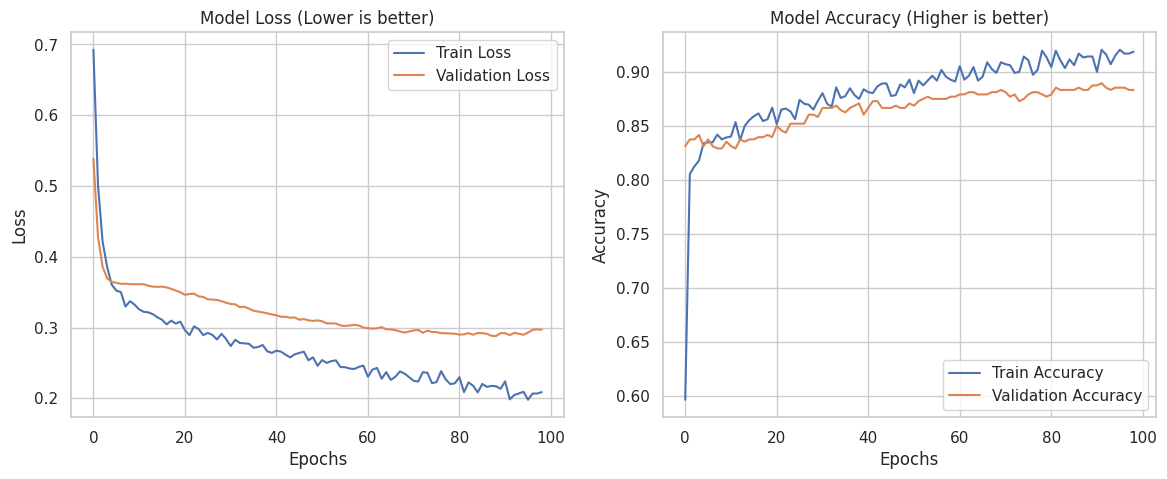

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

深度神经网络最终准确率: 0.8833

分类报告:
                  precision    recall  f1-score   support

high_bike_demand       0.64      0.64      0.64        78
 low_bike_demand       0.93      0.93      0.93       402

        accuracy                           0.88       480
       macro avg       0.79      0.79      0.79       480
    weighted avg       0.88      0.88      0.88       480



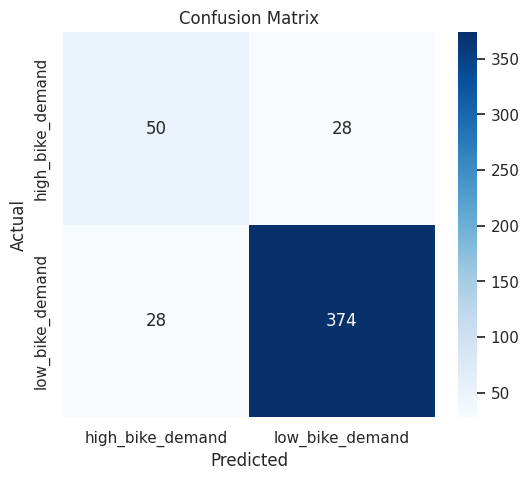

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 引入深度学习库
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 设置随机种子以保证结果可复现
tf.random.set_seed(42)
np.random.seed(42)

# ==========================================
# 1. 数据读取与预处理
# ==========================================
file_path = 'training_data_ht2025_updated.csv'
df = pd.read_csv(file_path)

# 标签编码
le = LabelEncoder()
df['target'] = le.fit_transform(df['increase_stock'])
# low_bike_demand -> 0, high_bike_demand -> 1

X = df.drop(['increase_stock', 'target'], axis=1)
y = df['target']

# 划分训练集和测试集 (7:3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 【关键步骤】数据标准化 (StandardScaler)
# 神经网络对特征的尺度非常敏感，必须进行标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"训练集形状: {X_train_scaled.shape}")
print(f"测试集形状: {X_test_scaled.shape}")

# ==========================================
# 2. 构建深度神经网络 (DNN) 模型
# ==========================================
model = Sequential()

# 输入层 + 第一个隐藏层
# input_dim=12 (特征数量), 64个神经元, ReLU激活函数
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dropout(0.3)) # 随机丢弃 30% 的神经元，防止过拟合

# 第二个隐藏层
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2)) # 随机丢弃 20% 的神经元

# 输出层
# 二分类任务，使用 sigmoid 函数将输出压缩到 0-1 之间
model.add(Dense(1, activation='sigmoid'))

# 编译模型
# 优化器: Adam (自适应学习率), 损失函数: 二元交叉熵
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

# ==========================================
# 3. 训练模型
# ==========================================
# 定义早停机制 (Early Stopping)：如果验证集 loss 在 10 轮内不下降，就停止训练
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

print("\n开始训练神经网络...")
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=200,          # 最大迭代轮数
    batch_size=64,       # 每次梯度更新使用的样本数
    callbacks=[early_stop],
    verbose=1
)

# ==========================================
# 4. 模型评估与可视化
# ==========================================

# 绘制训练过程中的 Loss 和 Accuracy 曲线
plt.figure(figsize=(14, 5))

# Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (Lower is better)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (Higher is better)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# 最终预测
# 神经网络输出的是概率，我们需要设定阈值 (0.5) 转换为类别
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32")

# 打印分类报告
acc = accuracy_score(y_test, y_pred)
print(f"\n深度神经网络最终准确率: {acc:.4f}")
print("\n分类报告:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()